## A/B test
---
**Elo notes**

In marketing and business intelligence, A/B testing is a term for a randomized experiment with two variants, A and B, which are the control and variation in the controlled experiment.

In online settings, such as web design (especially user experience design), the goal of A/B testing is to identify changes to web pages that increase or maximize an outcome of interest (e.g., click-through rate for a banner advertisement).

The current web page is associated with the null hypothesis. A/B testing is a way to compare two versions of a single variable typically by testing a subject's response to variable A against variable B, and determining which of the two variables is more effective.

#### Test statistics

"Two-sample hypothesis tests" are appropriate for comparing the two samples where the samples are divided by the two control cases in the experiment.

#### Segmentation and targeting

A/B tests most commonly apply the same variant (e.g., user interface element) with equal probability to all users. However, in some circumstances, responses to variants may be heterogeneous. That is, while a variant A might have a higher response rate overall, variant B may have an even higher response rate within a specific segment of the customer base.

It is important to note that if segmented results are expected from the A/B test, the test should be properly designed at the outset to be evenly distributed across key customer attributes, such as gender. That is, the test should both (a) contain a representative sample of men vs. women, and (b) assign men and women randomly to each “variant” (variant A vs. variant B). Failure to do so could lead to experiment bias and inaccurate conclusions to be drawn from the test.

This segmentation and targeting approach can be further generalized to include multiple customer attributes rather than a single customer attribute – for example, customers' age AND gender – to identify more nuanced patterns that may exist in the test results.




In [26]:
from __future__ import division

import pandas as pd
import numpy as np

import datetime as dt
import statsmodels.stats.power as spower
import scipy.stats as st

import matplotlib.pyplot as plt

from numpy import sqrt

%matplotlib inline

Historically, the old page has a conversion of 10% and we wish to test if the new page provides a 0.1% increase (1% lift) in conversion. Recall the null and alternative hypotheses below:

```
H0: X = 0.001
H1: X > 0.001
```

Note: Evaluating increase - one-tailed test.

In [6]:
df = pd.read_csv('ctr_experiment.csv' )

In [7]:
df.head()

,user_id,ts,ab,landing_page,converted
0,4040615247,1.356998e+09,treatment,new_page,0
1,4365389205,1.356998e+09,treatment,new_page,0
2,4256174578,1.356998e+09,treatment,new_page,0
3,8122359922,1.356998e+09,control,old_page,0
4,6077269891,1.356998e+09,control,old_page,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191148 entries, 0 to 191147
Data columns (total 5 columns):
user_id         191148 non-null int64
ts              191148 non-null float64
ab              191148 non-null object
landing_page    191148 non-null object
converted       191148 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 7.3+ MB


In [9]:
df['tstamp'] = df['ts'].apply(lambda x: dt.datetime.fromtimestamp(int(x)))

In [10]:
df[:3]

,user_id,ts,ab,landing_page,converted,tstamp
0,4040615247,1.356998e+09,treatment,new_page,0,2012-12-31 16:00:00
1,4365389205,1.356998e+09,treatment,new_page,0,2012-12-31 16:00:00
2,4256174578,1.356998e+09,treatment,new_page,0,2012-12-31 16:00:02


In [11]:
df.ab.unique()

array(['treatment', 'control'], dtype=object)

In [12]:
# Checking for duplicates in user_id
len(df.user_id.unique())

186388

In [13]:
df_ctrl = df[df.ab == 'control'].copy()
n_ctrl = float(len(df_ctrl.user_id.unique()))

In [14]:
df_treat = df[df.ab == 'treatment'].copy()
n_treat = float(len(df_treat.user_id.unique()))

In [15]:
conversion_rate_ctrl = df_ctrl.converted.sum() / n_ctrl
conversion_rate_ctrl

0.09964322681524874

In [16]:
conversion_rate_treat = df_treat.converted.sum() / n_treat
conversion_rate_treat

0.10492393328729571

 [I have to stackoverflow things](https://onlinecourses.science.psu.edu/stat100/node/56)
 
 
 Sample size Standard Error (SE) = Square root of (p * (1-p) / n) 
 
 where: 
 
 p = sample proportion : conversion rate : population proportion + random error.

In [17]:
def ztest(crate_ctrl, crate_treat, n_ctrl, n_treat, ttail=False, alpha=0.05):
    ''' 
    Arguments:
    crate_ctrl (float): Conversion rate of control df
    crate_treat (float):  Conversion rate of treatment df
    n_ctrl (int): number of observations in control
    n_treat (int): number of observations in treatment
    alpha (float): Significance level
    ttail (bool): two tailed
    Return:
    z-score, pvalue, desicion
    '''
    p = (crate_ctrl * n_ctrl + crate_treat * n_treat) / (n_ctrl + n_treat)
    se = sqrt(p * (1- p) * (1/n_ctrl + 1/n_treat))
    z_score = (crate_treat - crate_ctrl) / se
    
    if ttail:
        pval = (1 - st.norm.cdf(abs(z_score)))*2
    else:
        pval = 1 - st.norm.cdf(z_score)
    print
    
    reject_null = pval < alpha
    
    print 'pval:{}, z_score:{}, reject_null:{}'.format(pval, z_score, reject_null)
    return pval, z_score, reject_null
    

In [18]:
ztest(conversion_rate_ctrl, conversion_rate_treat, n_ctrl, n_treat)


pval:8.51269056524e-05, z_score:3.75949921572, reject_null:True


(8.512690565243286e-05, 3.7594992157238489, True)

#### Pvalue - hourly intervals

In [19]:
df_ctrl.tstamp[:3]

3   2012-12-31 16:00:02
4   2012-12-31 16:00:02
6   2012-12-31 16:00:04
Name: tstamp, dtype: datetime64[ns]

In [20]:
start = dt.datetime.fromtimestamp(int(df['ts'].min()))

In [21]:
start

datetime.datetime(2012, 12, 31, 16, 0)

In [22]:
end = dt.datetime.fromtimestamp(int(df.ts.max()))

In [23]:
end

datetime.datetime(2013, 1, 1, 15, 59, 59)


pval:0.0700598755515, z_score:1.47534523396, reject_null:False

pval:0.0365443483557, z_score:1.79227643133, reject_null:True

pval:0.0156446153757, z_score:2.15337484706, reject_null:True

pval:0.0092173551451, z_score:2.35676900278, reject_null:True

pval:0.00842540841945, z_score:2.38994672697, reject_null:True

pval:0.00291970966096, z_score:2.75666471825, reject_null:True

pval:0.00917643913335, z_score:2.35842074563, reject_null:True

pval:0.00439091992125, z_score:2.62043216923, reject_null:True

pval:0.00221711431059, z_score:2.84549621657, reject_null:True

pval:0.010762076953, z_score:2.2986617541, reject_null:True

pval:0.00976181202029, z_score:2.33537912333, reject_null:True

pval:0.00369460170534, z_score:2.67877497146, reject_null:True

pval:0.00404499176461, z_score:2.64829108034, reject_null:True

pval:0.0067209161516, z_score:2.47184356184, reject_null:True

pval:0.00997079915924, z_score:2.3274449012, reject_null:True

pval:0.0205266197778, z_score:2.0429919041, rej

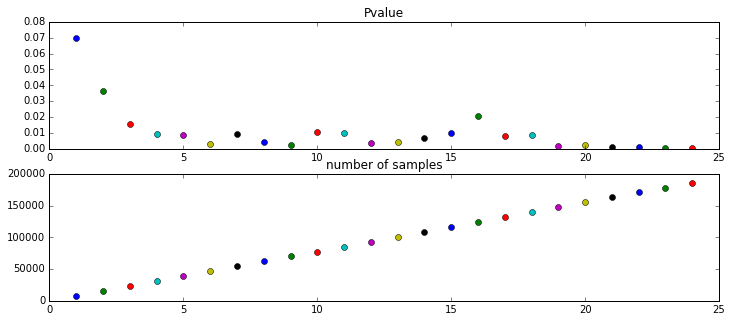

In [27]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,5))

for i in range(25)[1:]:
    ctl = df_ctrl[df_ctrl['tstamp'] < start + dt.timedelta(hours=i)]
    trt = df_treat[df_treat['tstamp'] < start + dt.timedelta(hours=i)]

    n_ctl = float(len(ctl.user_id.unique()))
    n_trt = float(len(trt.user_id.unique()))

    ctl_rate = ctl['converted'].sum() / n_ctl
    trt_rate = trt['converted'].sum() / n_trt
    
    (p, z, r) = ztest(ctl_rate, trt_rate, n_ctl, n_trt)
    ax1.plot(i, p, 'o')
    ax2.plot(i, n_ctl+n_trt, 'o')

ax1.set_title('Pvalue')
ax2.set_title('number of samples')

The P-value stabilize when we get a proper number of samples. To obtain the optimal sample number let's calculate it through Power.

In [28]:
dfc = pd.read_csv('ctr_country.csv')

In [29]:
dfc[:3]

,user_id,country
0,9160993935,UK
1,5879439034,UK
2,8915383273,UK


In [30]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185076 entries, 0 to 185075
Data columns (total 2 columns):
user_id    185076 non-null int64
country    185076 non-null object
dtypes: int64(1), object(1)
memory usage: 2.8+ MB


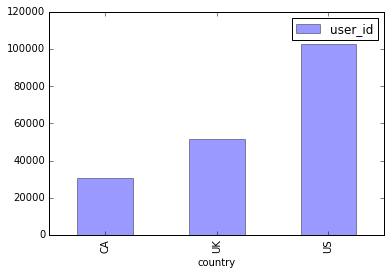

In [31]:
dfc.groupby('country').count().plot(kind='bar', alpha=.4);

Note: By default axis=0 along the rows (namely, index in pandas), and axis=1 along the columns.

In [32]:
def ctrl(df, *args, **kwargs):
    def funct(x):
        return x.converted.sum() / float(len(x['user_id'].unique()))
    return df.apply((lambda x: funct(x)), axis=1)

In [33]:
# Join: df + dfc
jdf = df.set_index('user_id').join(dfc.set_index('user_id'))

In [34]:
jdf[:3]

,ts,ab,landing_page,converted,tstamp,country
user_id,,,,,,
3416,1.357004e+09,control,old_page,0,2012-12-31 17:34:39,US
23267,1.357066e+09,treatment,new_page,0,2013-01-01 10:46:55,CA
79973,1.357018e+09,treatment,new_page,1,2012-12-31 21:28:31,US


In [35]:
jdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200344 entries, 3416 to 9999962347
Data columns (total 6 columns):
ts              200344 non-null float64
ab              200344 non-null object
landing_page    200344 non-null object
converted       200344 non-null int64
tstamp          200344 non-null datetime64[ns]
country         194274 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.7+ MB


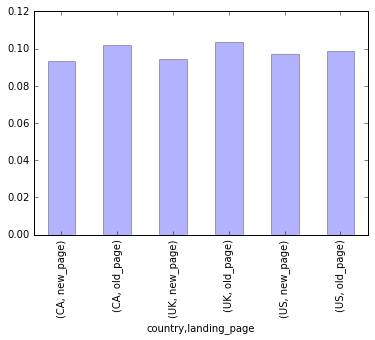

In [36]:
jdf.groupby(['country', 'landing_page']).apply(lambda x: x['converted'].sum()/ float(len(x))).plot(kind='bar', alpha=.3);

In [37]:
jdf[:3]

,ts,ab,landing_page,converted,tstamp,country
user_id,,,,,,
3416,1.357004e+09,control,old_page,0,2012-12-31 17:34:39,US
23267,1.357066e+09,treatment,new_page,0,2013-01-01 10:46:55,CA
79973,1.357018e+09,treatment,new_page,1,2012-12-31 21:28:31,US


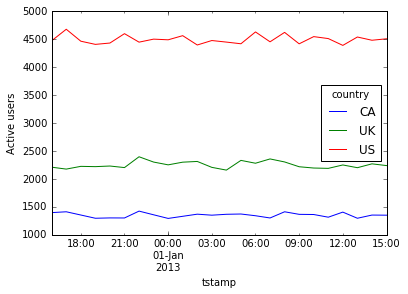

In [38]:
jdf.set_index('tstamp').groupby('country').apply(lambda x: x.resample('H').count()).ts.unstack().T.plot();
plt.ylabel('Active users');